# Serialising the Stars

Noodles lets you run jobs remotely and store/retrieve results in case of duplicate jobs or reruns. These features rely on the *serialisation* (and not unimportant, reconstruction) of all objects that are passed between scheduled functions. Serialisation refers to the process of turning any object into a stream of bytes from which we can reconstruct a functionally identical object. "Easy enough!" you might think, just use `pickle`. 

In [1]:
from noodles.tutorial import display_text
import pickle

function = pickle.dumps(str.upper)
message = pickle.dumps("Hello, Wold!")

display_text("function: " + str(function))
display_text("message: " + str(message))

In [2]:
pickle.loads(function)(pickle.loads(message))

'HELLO, WOLD!'

However `pickle` cannot serialise all objects ... "Use `dill`!" you say; still the pickle/dill method of serializing is rather indiscriminate. Some of our objects may contain runtime data we can't or don't want to store, coroutines, threads, locks, open files, you name it. We work with a Sqlite3 database to store our data. An application might store gigabytes of numerical data.  We don't want those binary blobs in our database, rather to store them externally in a HDF5 file.

There are many cases where a more fine-grained control of serialisation is in order. The bottom line being, that there is *no silver bullet solution*. Here we show some examples on how to customize the Noodles serialisation mechanism.

## The registry

Noodles keeps a registry of `Serialiser` objects that know exactly how to serialise and reconstruct objects. This registry is specified to the backend when we call the one of the `run` functions. To make the serialisation registry visible to remote parties it is important that the registry can be imported. This is why it has to be a function of zero arguments (a *thunk*) returning the actual registry object.

```python
def registry():
    return Registry(...)
    
run(workflow,
    db_file='project-cache.db',
    registry=registry)
```

The registry that should always be included is `noodles.serial.base`. This registry knows how to serialise basic Python dictionaries, lists, tuples, sets, strings, bytes, slices and all objects that are internal to Noodles. Special care is taken with objects that have a `__name__` attached and can be imported using the `__module__.__name__` combination.

Registries can be composed using the `+` operator. For instance, suppose we want to use `pickle` as a default option for objects that are not in `noodles.serial.base`:

In [3]:
import noodles

def registry():
    return noodles.serial.pickle() \
        + noodles.serial.base()

reg = registry()

Let's see what is made of our objects!

In [4]:
display_text(reg.to_json([
    "These data are JSON compatible!", 0, 1.3, None,
    {"dictionaries": "too!"}], indent=2))

Great! JSON compatible data stays the same. Now try an object that JSON doesn't know about.

In [5]:
display_text(reg.to_json({1, 2, 3}, indent=2), [1])

Objects are encoded as a dictionary containing a `'_noodles'` key. So what will happen if we serialise an object the registry cannot possibly know about? Next we define a little astronomical class describing a star in the [Morgan-Keenan classification scheme](https://en.wikipedia.org/wiki/Stellar_classification).

In [6]:
class Star(object):
    """Morgan-Keenan stellar classification."""
    def __init__(self, spectral_type, number, luminocity_class):
        assert spectral_type in "OBAFGKM"
        assert number in range(10)
        
        self.spectral_type = spectral_type
        self.number = number
        self.luminocity_class = luminocity_class

rigel = Star('B', 8, 'Ia')
display_text(reg.to_json(rigel, indent=2), [4], max_width=60)

The registry obviously doesn't know about `Star`s, so it falls back to serialisation using `pickle`. The pickled data is further encoded using `base64`. This solution won't work if some of your data cannot be pickled. Also, if you're sensitive to aesthetics, the pickled output doesn't look very nice.

## *serialize* and *construct*

One way to take control of the serialisation of your objects is to add the `__serialize__` and `__construct__` methods.

In [7]:
class Star(object):
    """Morgan-Keenan stellar classification."""
    def __init__(self, spectral_type, number, luminocity_class):
        assert spectral_type in "OBAFGKM"
        assert number in range(10)
        
        self.spectral_type = spectral_type
        self.number = number
        self.luminocity_class = luminocity_class
        
    def __str__(self):
        return f'{self.spectral_type}{self.number}{self.luminocity_class}'
    
    def __repr__(self):
        return f'Star.from_string(\'{str(self)}\')'
    
    @staticmethod
    def from_string(string):
        """Construct a new Star from a string describing the stellar type."""
        return Star(string[0], int(string[1]), string[2:])
    
    def __serialize__(self, pack):
        return pack(str(self))
    
    @classmethod
    def __construct__(cls, data):
        return Star.from_string(data)

The class became quite a bit bigger. However, the `__str__`, `__repr__` and `from_string` methods are part of an interface you'd normally implement to make your class more useful.

In [8]:
sun = Star('G', 2, 'V')
print("The Sun is a", sun, "type star.")

The Sun is a G2V type star.


In [9]:
encoded_star = reg.to_json(sun, indent=2)
display_text(encoded_star, [4])

The `__serialize__` method takes one argument (besides `self`). The argument `pack` is a function that creates the data record with all handles attached. The reason for this construct is that it takes keyword arguments for special cases.

```python
def pack(data, ref=None, files=None):
    pass
```

* The `ref` argument, if given as `True`, will make sure that this object will not get reconstructed unnecessarily. One instance where this is incredibly useful, is if the object is a gigabytes large Numpy array.
* The `files` argument, when given, should be a list of filenames. This makes sure Noodles knows about the involvement of external files.

The data passed to `pack` maybe of any type, as long as the serialisation registry knows how to serialise it.

The `__construct__` method must be a *class method*. The `data` argument it is given can be expected to be identical to the data passed to the `pack` function at serialisation.

In [10]:
decoded_star = reg.from_json(encoded_star)
display_text(repr(decoded_star))

## Writing a Serialiser class (example with large data)

Often, the class that needs serialising is not from your own package. In that case we need to write a specialised `Serialiser` class. For this purpose it may be nice to see how to serialise a Numpy array. This code is [already in Noodles](https://github.com/NLeSC/noodles/blob/master/noodles/serial/numpy.py); we will look at a trimmed down version.

Given a NumPy array, we need to do two things:

* Generate a token by which to identify the array; we will use a SHA-256 hash to do this.
* Store the array effeciently; the HDF5 fileformat is perfectly suited.

### SHA-256
We need to hash the combination of datatype, array shape and the binary data:

In [11]:
import numpy
import hashlib
import base64

def array_sha256(a):
    """Create a SHA256 hash from a Numpy array."""
    dtype = str(a.dtype).encode()
    shape = numpy.array(a.shape)
    sha = hashlib.sha256()
    sha.update(dtype)
    sha.update(shape)
    sha.update(a.tobytes())
    return base64.urlsafe_b64encode(sha.digest()).decode()

Is this useable for large data? Let's see how this scales (code to generate this plot is below):

![SHA-256 performance plot](./sha256-performance.svg)

So on my laptop, hashing an array of ~1 GB takes a little over three seconds, and it scales almost perfectly linear. Next we define the storage routine (and a loading routine, but that's a oneliner).

In [13]:
import h5py

def save_array_to_hdf5(filename, lock, array):
    """Save an array to a HDF5 file, using the SHA-256 of the array
    data as path within the HDF5. The `lock` is needed to prevent
    simultaneous access from multiple threads."""
    hdf5_path = array_sha256(array)
    with lock, h5py.File(filename) as hdf5_file:
        if not hdf5_path in hdf5_file:
            dataset = hdf5_file.create_dataset(
                hdf5_path, shape=array.shape, dtype=array.dtype)
            dataset[...] = array
            hdf5_file.close()

    return hdf5_path

And put it all together in a class derived from `SerArray`.

In [14]:
import filelock
from noodles.serial import Serialiser, Registry


class SerArray(Serialiser):
    """Serialises Numpy array to HDF5 file."""
    def __init__(self, filename, lockfile):
        super().__init__(numpy.ndarray)
        self.filename = filename
        self.lock = filelock.FileLock(lockfile)

    def encode(self, obj, pack):
        key = save_array_to_hdf5(self.filename, self.lock, obj)
        return pack({
            "filename": self.filename,
            "hdf5_path": key,
        }, files=[self.filename], ref=True)

    def decode(self, cls, data):
        with self.lock, h5py.File(self.filename) as hdf5_file:
            return hdf5_file[data["hdf5_path"]].value

We have to insert the serialiser into a new registry.

In [15]:
!rm -f tutorial.h5  # remove from previous run

In [16]:
import noodles
from noodles.tutorial import display_text

def registry():
    return Registry(
        parent=noodles.serial.base(),
        types={
            numpy.ndarray: SerArray('tutorial.h5', 'tutorial.lock')
        })

reg = registry()

Now we can serialise our first Numpy array!

In [17]:
encoded_array = reg.to_json(numpy.arange(10), host='localhost', indent=2)
display_text(encoded_array, [6])

Now, we should be able to read back the data directly from the HDF5.

In [19]:
with h5py.File('tutorial.h5') as f:
    result = f['4Z8kdMg-CbjgTKKYlz6b-_-Tsda5VAJL44OheRB10mU='][()]
print(result)

[0 1 2 3 4 5 6 7 8 9]


We have set the `ref` property to `True`, we can now read back the serialised object without dereferencing. This will result in a placeholder object containing only the encoded data:

In [20]:
ref = reg.from_json(encoded_array)
display_text(ref)
display_text(vars(ref), max_width=60)

If we want to retrieve the data we should run `from_json` with `deref=True`:

In [21]:
display_text(reg.from_json(encoded_array, deref=True))

## Appendix A: better parsing
If you're interested in doing a bit better in parsing generic expressions into objects, take a look at `pyparsing`.

In [22]:
!pip install pyparsing

The following code will parse the stellar types we used before:

In [23]:
from pyparsing import Literal, replaceWith, OneOrMore, Word, nums, oneOf

def roman_numeral_literal(string, value):
    return Literal(string).setParseAction(replaceWith(value))
    
one = roman_numeral_literal("I", 1)
four = roman_numeral_literal("IV", 4)
five = roman_numeral_literal("V", 5)

roman_numeral = OneOrMore(
    (five | four | one).leaveWhitespace()) \
    .setName("roman") \
    .setParseAction(lambda s, l, t: sum(t))

integer = Word(nums) \
    .setName("integer") \
    .setParseAction(lambda t:int(t[0]))

mkStar = oneOf(list("OBAFGKM")) + integer + roman_numeral

In [24]:
list(mkStar.parseString('B2IV'))

['B', 2, 4]

In [25]:
roman_class = {
    'I': 'supergiant',
    'II': 'bright giant',
    'III': 'regular giant',
    'IV': 'sub-giants',
    'V': 'main-sequence',
    'VI': 'sub-dwarfs',
    'VII': 'white dwarfs'
}

## Appendix B: measuring SHA-256 performance

scaling: 0.9959622789961061 (should be ~1)
speed: 0.3728006090297612 GB/s


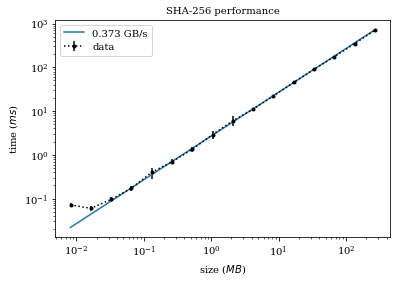

In [27]:
import timeit
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "serif"
from scipy import stats


def benchmark(size, number=10):
    """Measure performance of SHA-256 hashing large arrays."""
    data = numpy.random.uniform(size=size)
    return timeit.timeit(
        stmt=lambda: array_sha256(data),
        number=number) / number


sizes = numpy.logspace(10, 25, 16, base=2, dtype=int)
timings = numpy.array([[benchmark(size, 1) for size in sizes]
                       for i in range(10)])

sizes_MB = sizes * 8 / 1e6
timings_ms = timings.mean(axis=0) * 1000
timings_err = timings.std(axis=0) * 1000

slope, intercept, _, _, _ = stats.linregress(
    numpy.log(sizes_MB[5:]),
    numpy.log(timings_ms[5:]))

print("scaling:", slope, "(should be ~1)")
print("speed:", numpy.exp(-intercept), "GB/s")

ax = plt.subplot(111)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
ax.plot(sizes_MB, numpy.exp(intercept) * sizes_MB,
        label='{:.03} GB/s'.format(numpy.exp(-intercept)))
ax.errorbar(sizes_MB, timings_ms, yerr=timings_err,
            marker='.', ls=':', c='k', label='data')
ax.set_xlabel('size ($MB$)')
ax.set_ylabel('time ($ms$)')
ax.set_title('SHA-256 performance', fontsize=10)
ax.legend()
plt.savefig('sha256-performance.svg')
plt.show()

## Implementation

A `Registry` object roughly consists of three parts. It works like a dictionary searching for `Serialiser`s based on the class or baseclass of an object. If an object cannot be identified through its class or baseclasses the `Registry` has a function hook that may use any test to determine the proper `Serialiser`. When neither the hook nor the dictionary give a result, there is a default fall-back option.